In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('../../data/ai4i2020.csv')

# 2. Chọn các cột đặc trưng và nhãn
features = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
labels = data['Machine failure']  # Nhãn bất thường

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. Chọn 8000 dòng dữ liệu bình thường (Machine failure = 0) để huấn luyện
X_train = scaled_features[labels == 0][:8000]  # Lấy 8000 dòng bình thường
print(f"Tập huấn luyện: {X_train.shape}")

# 5. Chọn 5000 dòng ngẫu nhiên bao gồm cả bình thường và bất thường cho kiểm tra
test_data = data.sample(n=5000, random_state=42)
X_test = scaler.transform(test_data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']))
y_test = test_data['Machine failure'].values  # Nhãn thực tế của tập kiểm tra
print(f"Tập kiểm tra: {X_test.shape}")

# 6. Chuyển đổi sang Tensor cho PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 7. Định nghĩa mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2)  # Output là mean và logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=-1)  # Tách mean và logvar
        z = self.reparameterize(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

# 8. Khởi tạo mô hình, loss, và optimizer
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 9. Huấn luyện mô hình VAE
epochs = 50
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=32, shuffle=True)

model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = nn.MSELoss()(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# 10. Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()



Tập huấn luyện: (8000, 5)
Tập kiểm tra: (5000, 5)
Epoch 1, Loss: 0.0495
Epoch 2, Loss: 0.0315
Epoch 3, Loss: 0.0306
Epoch 4, Loss: 0.0304
Epoch 5, Loss: 0.0303
Epoch 6, Loss: 0.0302
Epoch 7, Loss: 0.0302
Epoch 8, Loss: 0.0301
Epoch 9, Loss: 0.0301
Epoch 10, Loss: 0.0301
Epoch 11, Loss: 0.0301
Epoch 12, Loss: 0.0301
Epoch 13, Loss: 0.0301
Epoch 14, Loss: 0.0301
Epoch 15, Loss: 0.0301
Epoch 16, Loss: 0.0301
Epoch 17, Loss: 0.0301
Epoch 18, Loss: 0.0301
Epoch 19, Loss: 0.0301
Epoch 20, Loss: 0.0301
Epoch 21, Loss: 0.0301
Epoch 22, Loss: 0.0300
Epoch 23, Loss: 0.0301
Epoch 24, Loss: 0.0300
Epoch 25, Loss: 0.0300
Epoch 26, Loss: 0.0301
Epoch 27, Loss: 0.0301
Epoch 28, Loss: 0.0301
Epoch 29, Loss: 0.0300
Epoch 30, Loss: 0.0301
Epoch 31, Loss: 0.0300
Epoch 32, Loss: 0.0300
Epoch 33, Loss: 0.0300
Epoch 34, Loss: 0.0300
Epoch 35, Loss: 0.0301
Epoch 36, Loss: 0.0300
Epoch 37, Loss: 0.0300
Epoch 38, Loss: 0.0300
Epoch 39, Loss: 0.0300
Epoch 40, Loss: 0.0301
Epoch 41, Loss: 0.0300
Epoch 42, Loss: 

In [8]:
# 11. Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 97)  # Ngưỡng 95%
print(f"Ngưỡng phát hiện: {threshold}")

# 12. Dự đoán bất thường
y_pred = (reconstruction_loss > threshold).astype(int)

# 13. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Ngưỡng phát hiện: 2.146908111572267
Confusion Matrix:
 [[4541  296]
 [ 109   54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      4837
           1       0.15      0.33      0.21       163

    accuracy                           0.92      5000
   macro avg       0.57      0.64      0.58      5000
weighted avg       0.95      0.92      0.93      5000



ROC AUC Score: 0.6784874009266506


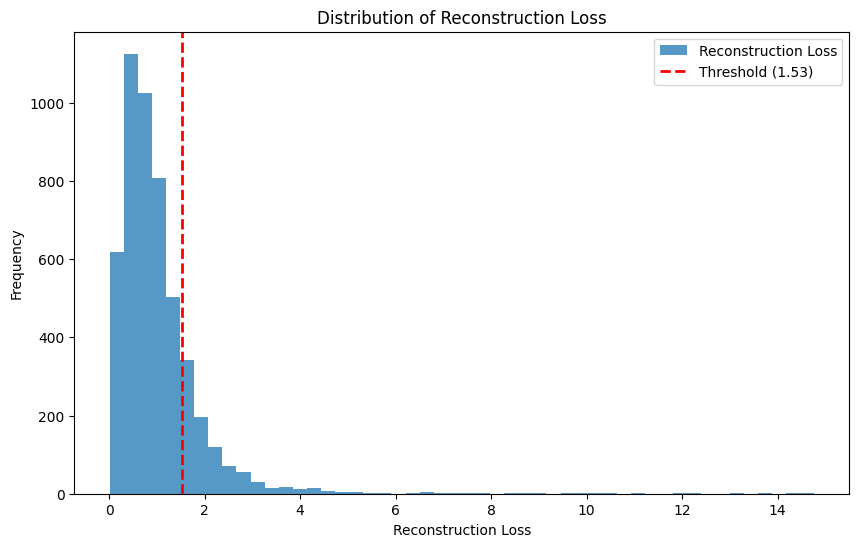

In [3]:
# 14. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# 15. Vẽ biểu đồ của reconstruction_loss và ngưỡng
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()